Using device: cpu
CNN for CIFAR-10 Classification
Loading CIFAR-10 dataset...

Model Architecture:
CNN(
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

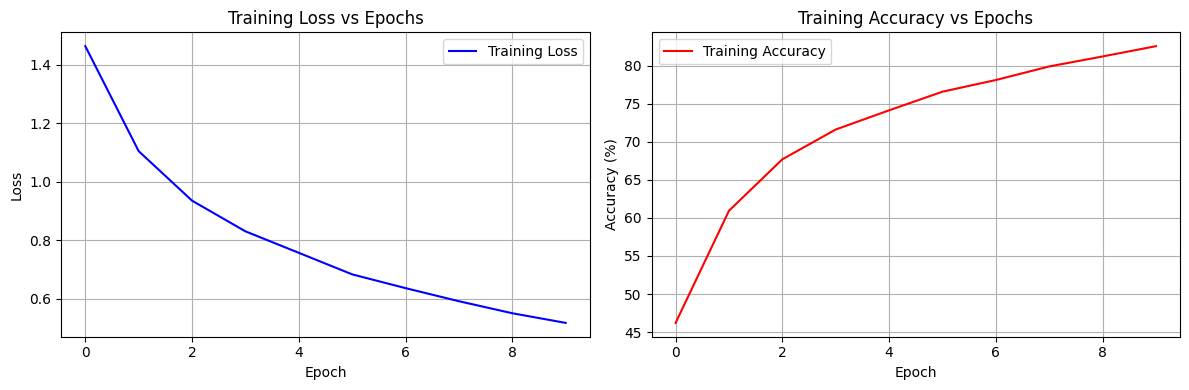

Test Accuracy: 81.48%
Precision: 0.8141
Recall: 0.8148
F1-Score: 0.8121


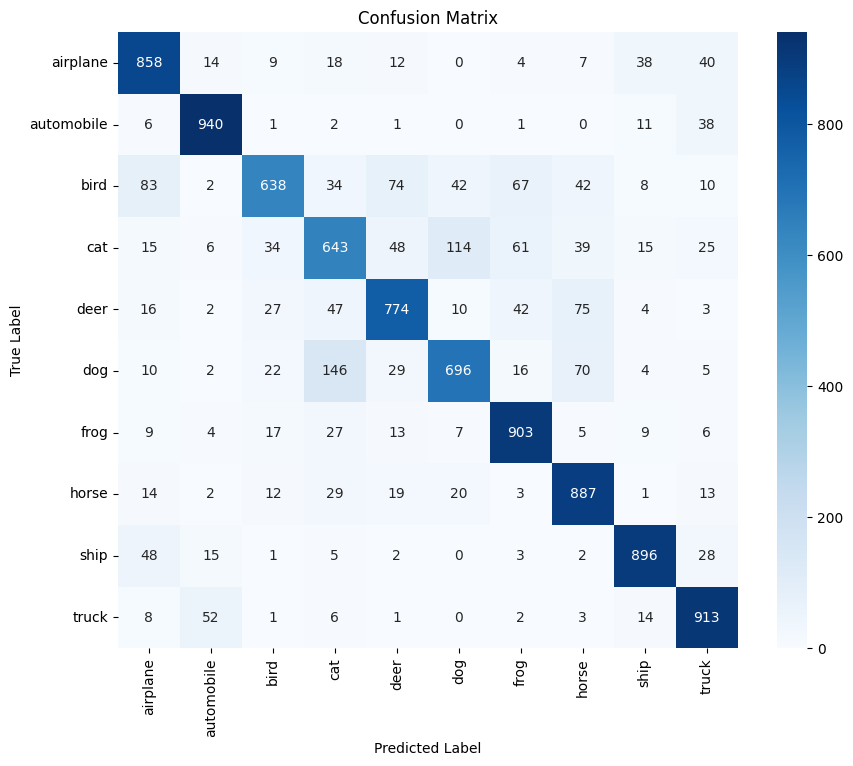

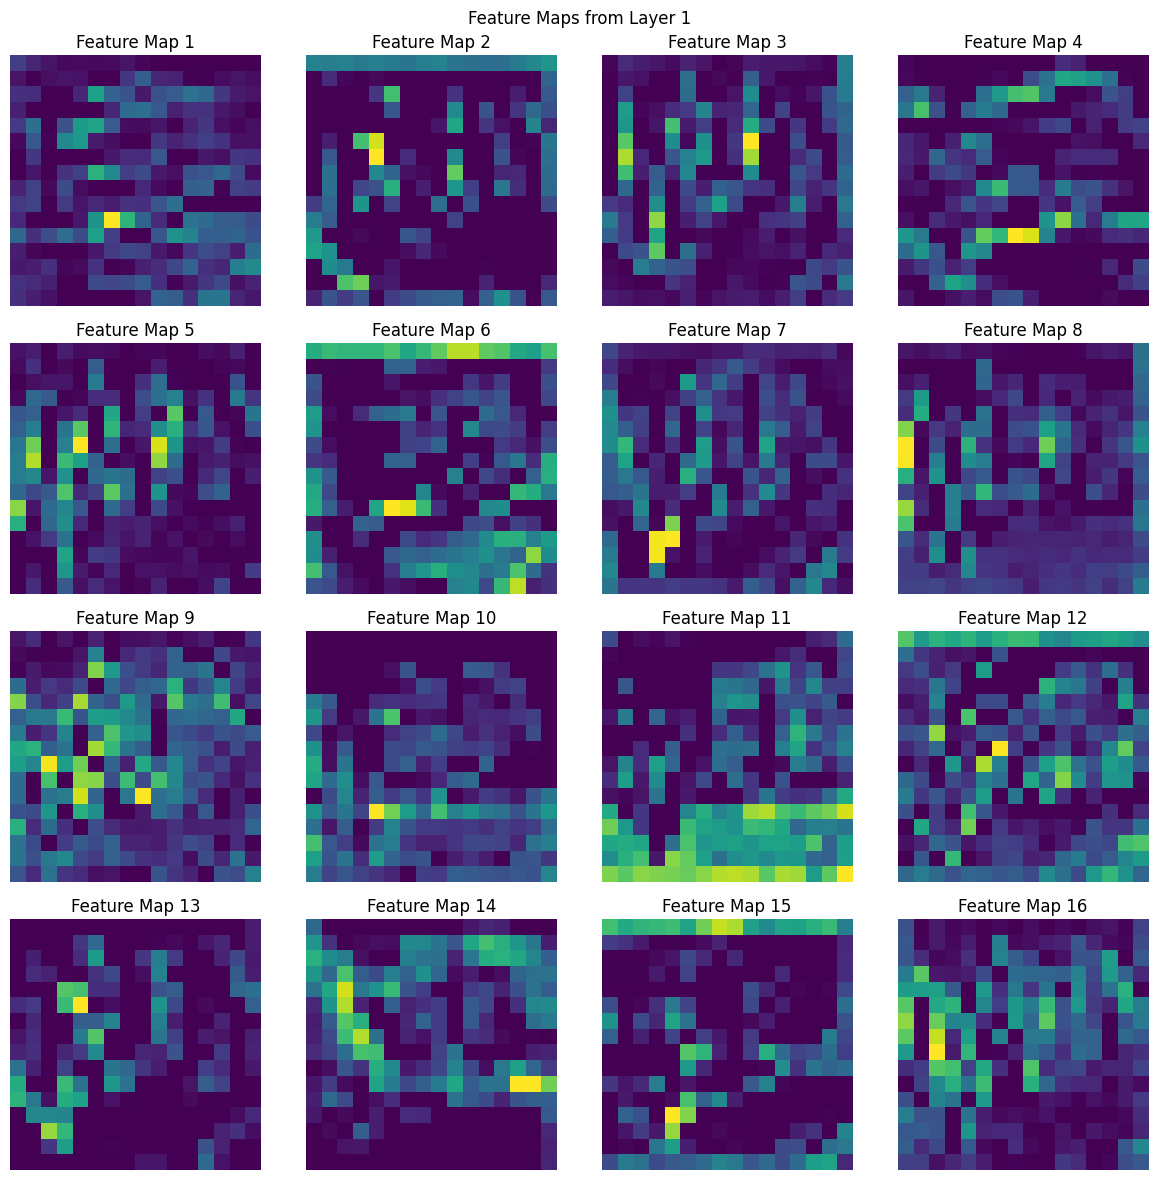

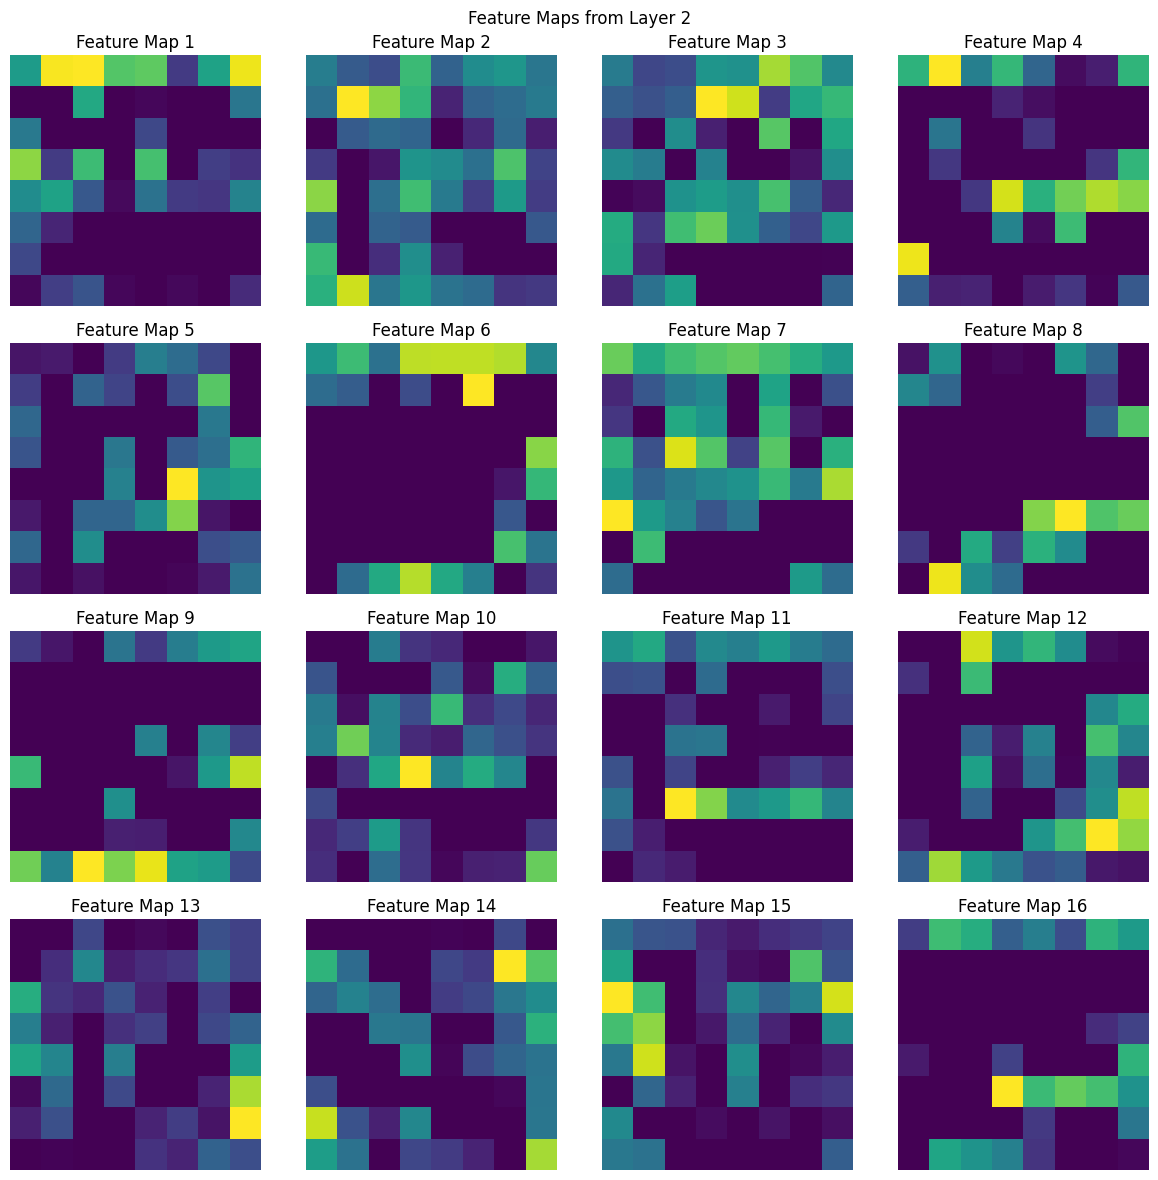

Starting Hyperparameter Ablation Study...
Loading CIFAR-10 dataset...

=== Learning Rate Ablation ===

Testing Learning Rate: 0.001
Training for 5 epochs...
Epoch [1/5], Step [0/1563], Loss: 2.3745, Accuracy: 3.12%
Epoch [1/5], Step [100/1563], Loss: 1.7775, Accuracy: 23.98%
Epoch [1/5], Step [200/1563], Loss: 1.7619, Accuracy: 28.11%


KeyboardInterrupt: 

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
import itertools
from datasets import load_dataset
from PIL import Image

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

class CNN(nn.Module):
    """
    Convolutional Neural Network for CIFAR-10 classification
    """
    def __init__(self, num_filters=32, num_layers=3):
        super(CNN, self).__init__()
        
        # Store parameters for ablation study
        self.num_filters = num_filters
        self.num_layers = num_layers
        
        # Build convolutional layers dynamically
        self.conv_layers = nn.ModuleList()
        in_channels = 3  # RGB input
        
        for i in range(num_layers):
            out_channels = num_filters * (2 ** i)  # Double filters each layer
            self.conv_layers.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(kernel_size=2, stride=2)
                )
            )
            in_channels = out_channels
        
        # Calculate the size after convolutions
        # For CIFAR-10 (32x32), after num_layers of pooling: 32 / (2^num_layers)
        final_size = 32 // (2 ** num_layers)
        final_channels = num_filters * (2 ** (num_layers - 1))
        
        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(final_channels * final_size * final_size, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 10)  # 10 classes
        )
        
    def forward(self, x):
        # Store feature maps for visualization
        self.feature_maps = []
        
        # Pass through convolutional layers
        for conv_layer in self.conv_layers:
            x = conv_layer(x)
            self.feature_maps.append(x.clone())
        
        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)
        
        # Classification
        x = self.classifier(x)
        return x

def load_cifar10_data():
    """
    Load CIFAR-10 dataset from Hugging Face
    """
    print("Loading CIFAR-10 dataset...")
    
    # Load dataset from Hugging Face
    dataset = load_dataset("uoft-cs/cifar10")
    
    # Define transforms
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    
    # Convert HF dataset to PyTorch format
    def transform_dataset(dataset_split, transform):
        def transform_fn(examples):
            examples['pixel_values'] = [transform(img.convert('RGB')) for img in examples['img']]
            return examples
        
        dataset_split = dataset_split.map(transform_fn, batched=True)
        dataset_split.set_format(type='torch', columns=['pixel_values', 'label'])
        return dataset_split
    
    train_dataset = transform_dataset(dataset['train'], transform_train)
    test_dataset = transform_dataset(dataset['test'], transform_test)
    
    return train_dataset, test_dataset

# Global collate function to avoid multiprocessing issues
def collate_fn(batch):
    pixel_values = torch.stack([item['pixel_values'] for item in batch])
    labels = torch.tensor([item['label'] for item in batch])
    return pixel_values, labels

def create_data_loaders(train_dataset, test_dataset, batch_size=32):
    """
    Create data loaders for training and testing
    """
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             collate_fn=collate_fn, num_workers=0)  # Set to 0 for Windows compatibility
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, 
                            collate_fn=collate_fn, num_workers=0)   # Set to 0 for Windows compatibility
    
    return train_loader, test_loader

def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    """
    Train the CNN model
    """
    model.train()
    train_losses = []
    train_accuracies = []
    
    print(f"Training for {num_epochs} epochs...")
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (data, targets) in enumerate(train_loader):
            data, targets = data.to(device), targets.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            if batch_idx % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_loader)}], '
                      f'Loss: {loss.item():.4f}, Accuracy: {100.*correct/total:.2f}%')
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')
    
    return train_losses, train_accuracies

def evaluate_model(model, test_loader):
    """
    Evaluate the model and return predictions and metrics
    """
    model.eval()
    all_predictions = []
    all_targets = []
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    accuracy = 100. * correct / total
    precision, recall, f1, _ = precision_recall_fscore_support(all_targets, all_predictions, average='macro')
    
    print(f'Test Accuracy: {accuracy:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-Score: {f1:.4f}')
    
    return all_predictions, all_targets, accuracy, precision, recall, f1

def plot_training_curves(train_losses, train_accuracies):
    """
    Plot training loss and accuracy curves
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot loss
    ax1.plot(train_losses, 'b-', label='Training Loss')
    ax1.set_title('Training Loss vs Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracy
    ax2.plot(train_accuracies, 'r-', label='Training Accuracy')
    ax2.set_title('Training Accuracy vs Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Plot confusion matrix
    """
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    return cm

def visualize_feature_maps(model, test_loader, layer_idx=0):
    """
    Visualize feature maps from a specific convolutional layer
    """
    model.eval()
    
    # Get a batch of test data
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    images = images.to(device)
    
    # Forward pass to get feature maps
    with torch.no_grad():
        _ = model(images)
        feature_maps = model.feature_maps[layer_idx]
    
    # Select first image and first 16 feature maps
    feature_maps = feature_maps[0]  # First image
    feature_maps = feature_maps[:16]  # First 16 channels
    
    # Plot feature maps
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    for i, ax in enumerate(axes.flat):
        if i < len(feature_maps):
            ax.imshow(feature_maps[i].cpu().numpy(), cmap='viridis')
            ax.set_title(f'Feature Map {i+1}')
        ax.axis('off')
    
    plt.suptitle(f'Feature Maps from Layer {layer_idx + 1}')
    plt.tight_layout()
    plt.show()

def hyperparameter_ablation_study():
    """
    Conduct ablation study on different hyperparameters
    """
    print("Starting Hyperparameter Ablation Study...")
    
    # Load data once
    train_dataset, test_dataset = load_cifar10_data()
    
    results = []
    
    # 1. Learning Rate Study
    print("\n=== Learning Rate Ablation ===")
    learning_rates = [0.001, 0.01, 0.1]
    
    for lr in learning_rates:
        print(f"\nTesting Learning Rate: {lr}")
        train_loader, test_loader = create_data_loaders(train_dataset, test_dataset, batch_size=32)
        
        model = CNN().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        # Train for fewer epochs for ablation
        train_losses, train_accs = train_model(model, train_loader, criterion, optimizer, num_epochs=5)
        _, _, accuracy, precision, recall, f1 = evaluate_model(model, test_loader)
        
        results.append({
            'experiment': 'Learning Rate',
            'value': lr,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        })
    
    # 2. Batch Size Study
    print("\n=== Batch Size Ablation ===")
    batch_sizes = [16, 32, 64]
    
    for batch_size in batch_sizes:
        print(f"\nTesting Batch Size: {batch_size}")
        train_loader, test_loader = create_data_loaders(train_dataset, test_dataset, batch_size=batch_size)
        
        model = CNN().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        train_losses, train_accs = train_model(model, train_loader, criterion, optimizer, num_epochs=5)
        _, _, accuracy, precision, recall, f1 = evaluate_model(model, test_loader)
        
        results.append({
            'experiment': 'Batch Size',
            'value': batch_size,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        })
    
    # 3. Number of Filters Study
    print("\n=== Number of Filters Ablation ===")
    num_filters = [16, 32, 64]
    
    for filters in num_filters:
        print(f"\nTesting Number of Filters: {filters}")
        train_loader, test_loader = create_data_loaders(train_dataset, test_dataset, batch_size=32)
        
        model = CNN(num_filters=filters).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        train_losses, train_accs = train_model(model, train_loader, criterion, optimizer, num_epochs=5)
        _, _, accuracy, precision, recall, f1 = evaluate_model(model, test_loader)
        
        results.append({
            'experiment': 'Num Filters',
            'value': filters,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        })
    
    # 4. Number of Layers Study
    print("\n=== Number of Layers Ablation ===")
    num_layers = [3, 5, 7]
    
    for layers in num_layers:
        print(f"\nTesting Number of Layers: {layers}")
        train_loader, test_loader = create_data_loaders(train_dataset, test_dataset, batch_size=32)
        
        model = CNN(num_layers=layers).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        train_losses, train_accs = train_model(model, train_loader, criterion, optimizer, num_epochs=5)
        _, _, accuracy, precision, recall, f1 = evaluate_model(model, test_loader)
        
        results.append({
            'experiment': 'Num Layers',
            'value': layers,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        })
    
    return results

def print_results_table(results):
    """
    Print results in a formatted table
    """
    print("\n" + "="*80)
    print("HYPERPARAMETER ABLATION STUDY RESULTS")
    print("="*80)
    print(f"{'Experiment':<15} {'Value':<10} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
    print("-"*80)
    
    for result in results:
        print(f"{result['experiment']:<15} {result['value']:<10} {result['accuracy']:<10.2f} "
              f"{result['precision']:<10.4f} {result['recall']:<10.4f} {result['f1']:<10.4f}")

def main():
    """
    Main function to run the complete CNN pipeline
    """
    print("CNN for CIFAR-10 Classification")
    print("="*50)
    
    # Load dataset
    train_dataset, test_dataset = load_cifar10_data()
    train_loader, test_loader = create_data_loaders(train_dataset, test_dataset, batch_size=32)
    
    # Initialize model
    model = CNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    print(f"\nModel Architecture:")
    print(model)
    print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Train model
    train_losses, train_accuracies = train_model(model, train_loader, criterion, optimizer, num_epochs=10)
    
    # Plot training curves
    plot_training_curves(train_losses, train_accuracies)
    
    # Evaluate model
    predictions, targets, accuracy, precision, recall, f1 = evaluate_model(model, test_loader)
    
    # Plot confusion matrix
    cm = plot_confusion_matrix(targets, predictions, class_names)
    
    # Visualize feature maps
    visualize_feature_maps(model, test_loader, layer_idx=0)
    visualize_feature_maps(model, test_loader, layer_idx=1)
    
    # Conduct ablation study
    ablation_results = hyperparameter_ablation_study()
    print_results_table(ablation_results)
    
    # Print final metrics
    print(f"\n" + "="*50)
    print("FINAL MODEL PERFORMANCE")
    print("="*50)
    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

if __name__ == "__main__":
    main()